# Distributed lag models for tmean and tvar
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns

Data locations

In [2]:
loc_panel = "../Data/Panel/"
loc_regression = "../Data/RegressionResults/"
loc_shp = "../Data/Shapefile/"

#### Analysis

Read panel to get scalings etc

In [3]:
edd_type = "month"
panel = pd.read_csv(loc_panel+"extremes_growth_panel_"+edd_type+"edd_1979-2016.csv",index_col=0)

In [4]:
panel_mean = panel.groupby("region").mean().reset_index().loc[:,["region","t"]]

Plot

In [5]:
boot_type = "region"
extr = "tx5d"

In [6]:
seas = np.arange(0,40+1,1)
ts = np.arange(-5,35+1,1)
tx_ex = np.arange(5,50+1,1)

# for each value in ts, calculate the average tx5d found in its bin
tx_t = np.zeros(len(ts))
for tt in np.arange(0,len(tx_t),1):
    t1 = ts[tt]-1
    t2 = ts[tt]+1
    tx_t[tt] = np.nanmean(panel.loc[(panel.t>=t1)&(panel.t<t2),"tx5d"].values)

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


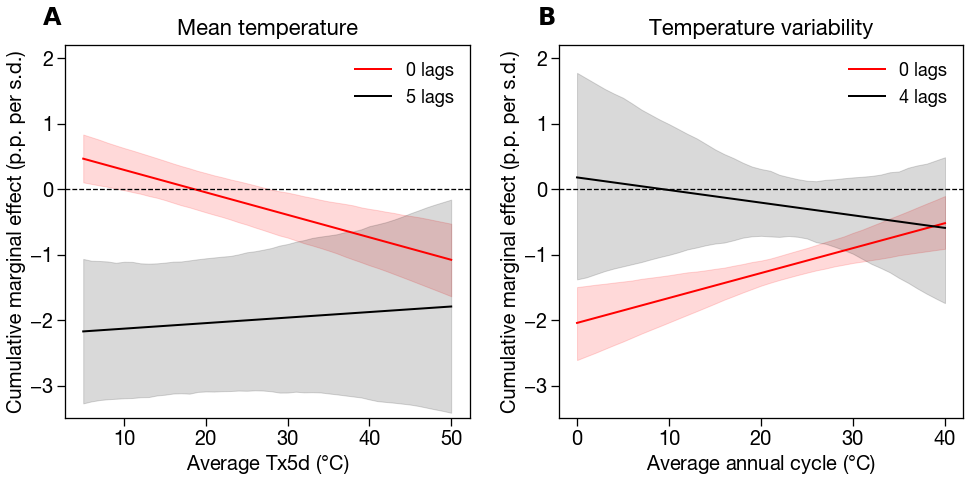

In [7]:
fig = plt.figure(figsize=(16,7))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.15,right=0.93,top=0.88,bottom=0.14,wspace=0.22,hspace=0.3)

nlag_mdl = [0,5]
nlag_t = [0,5]
nlag_tvar = [0,4]
#cols = ["red","blue","black"]
cols = ["red","black"]
panel_nms = ["t","var"]
coef_names = ["temperature","variability"]
ttls = ["Mean temperature","Temperature variability"]
arcode = ""

for j in [0,1]:

    ax = plt.subplot(gs1[0,j])
    
    scaling = 100*np.nanmean(panel.groupby("region").std()[panel_nms[j]].values)
    if coef_names[j]=="temperature":
        xvar = tx_ex # ts
    else:
        xvar = seas
    
    if coef_names[j]=="temperature":
        for ll in np.arange(0,len(nlag_t),1):
            l = nlag_t[ll]
            if l == 0:
                coefs_in = pd.read_csv(loc_regression+coef_names[j]+"_coefs_"+extr+"_model_bootstrap_contemporaneous.csv",index_col=0)
                coefs_main = coefs_in.coef_t.values
                coefs_interact = coefs_in.coef_t2.values
                coefs_interact2 = pd.read_csv(loc_regression+extr+"_coefs_bootstrap_contemporaneous.csv",index_col=0).coef_interact.values
                
            else:
                coefs_main_df = pd.read_csv(loc_regression+coef_names[j]+"_coefs_"+extr+"_model_bootstrap_"+boot_type+"_lag"+str(nlag_mdl[ll])+arcode+".csv",index_col=0)
                coefs_intr_df = pd.read_csv(loc_regression+coef_names[j]+"_coefs_interact_"+extr+"_model_bootstrap_"+boot_type+"_lag"+str(nlag_mdl[ll])+arcode+".csv",index_col=0)
                coefs_main = coefs_main = np.sum(coefs_main_df.iloc[:,1:(l+1)].values,axis=1)
                coefs_interact = np.sum(coefs_intr_df.iloc[:,1:(l+1)].values,axis=1)
                
                coefs_interact2_df = pd.read_csv(loc_regression+extr+"_coefs_interact_bootstrap_"+boot_type+"_lag"+str(l)+arcode+".csv",index_col=0)
                coefs_interact2 = np.sum(coefs_interact2_df.iloc[:,1:(l+1)].values,axis=1)
            
            if l!=1:
                lb = str(l)+" lags"
            else:
                lb = "1 lag"
                
            boot = np.arange(0,len(coefs_main),1)
            nboot = len(boot)
            me = np.zeros((nboot,len(xvar)))
            for n in np.arange(0,nboot,1):
                #me[n,:] = scaling*(coefs_main[n] + 2*coefs_interact[n]*xvar + coefs_interact2[n]*tx_t)
                me[n,:] = scaling*(coefs_main[n] + coefs_interact2[n]*tx_ex)
            me_mean = np.mean(me,axis=0)
            me_lower = np.percentile(me,2.5,axis=0)
            me_upper = np.percentile(me,97.5,axis=0)

            plt.plot(xvar,me_mean,color=cols[nlag_t.index(l)],linewidth=2,
                    label=lb)
            ax.fill_between(xvar,me_lower,me_upper,
                           color=cols[nlag_t.index(l)],alpha=0.15)
        
    if coef_names[j]=="variability":
        for ll in np.arange(0,len(nlag_tvar),1):
            l = nlag_tvar[ll]
            if l==0:
                all_coefs = pd.read_csv(loc_regression+coef_names[j]+"_coefs_"+extr+"_model_bootstrap_contemporaneous.csv",index_col=0)
                coefs_main = all_coefs.coef_var.values
                coefs_intr = all_coefs.coef_interact.values
                
            else:
                coefs_main_df = pd.read_csv(loc_regression+coef_names[j]+"_coefs_"+extr+"_model_bootstrap_"+boot_type+"_lag"+str(nlag_mdl[ll])+arcode+".csv",index_col=0)
                coefs_intr_df = pd.read_csv(loc_regression+coef_names[j]+"_coefs_interact_"+extr+"_model_bootstrap_"+boot_type+"_lag"+str(nlag_mdl[ll])+arcode+".csv",index_col=0)
                coefs_main = np.sum(coefs_main_df.iloc[:,1:(l+1)].values,axis=1)
                coefs_intr = np.sum(coefs_intr_df.iloc[:,1:(l+1)].values,axis=1)
                
            if l!=1:
                lb = str(l)+" lags"
            else:
                lb = "1 lag"
                
            boot = np.arange(0,len(coefs_main),1)
            nboot = len(boot)
            me = np.zeros((nboot,len(xvar)))
            for n in np.arange(0,nboot,1):
                me[n,:] = scaling*(coefs_main[n] + coefs_intr[n]*xvar)
            me_mean = np.mean(me,axis=0)
            me_lower = np.percentile(me,2.5,axis=0)
            me_upper = np.percentile(me,97.5,axis=0)

            plt.plot(xvar,me_mean,color=cols[nlag_tvar.index(l)],linewidth=2,
                    label=lb)
            ax.fill_between(xvar,me_lower,me_upper,
                           color=cols[nlag_tvar.index(l)],alpha=0.15)
            
    
    plt.axhline(y=0,color="black",linewidth=1.3,linestyle="--")
    
    plt.ylabel("Cumulative marginal effect (p.p. per s.d.)")
    if j == 0:
        plt.legend(loc="upper right",frameon=False,fontsize=18)
        plt.xlabel("Average Tx5d ($\degree$C)")
        plt.title("Mean temperature",pad=10,fontsize=22)
    else:
        plt.legend(loc="upper right",frameon=False,fontsize=18)
        plt.xlabel("Average annual cycle ($\degree$C)")
        plt.title("Temperature variability",pad=10,fontsize=22)
    plt.ylim([-3.5,2.2])
        
plt.figtext(0.13,0.92,r'$\bf{A}$',fontsize=24)
plt.figtext(0.56,0.92,r'$\bf{B}$',fontsize=24)

plt.savefig("../Figures/FigX_Tmean_Tvar_DL.pdf")
plt.show()